# Lab 02: Softmax Regression

## Notebook 01: Data Exploration and Pre-processing

*Note:*
To keep the pipeline minimal, easy to code, and easy to maintain, we decided to use functions for most steps (splitting the dataset, feature engineering, metrics, visualization, etc.).

However, if we only import functions from the `src/*.py` files, the notebook will contain very little visible content. Important NumPy-based implementations (which are part of the grading criteria) would require the instructor to open the `.py` files to review them.

Therefore, we chose to show these key functions again inside the `01_preprocessing.ipynb` file, together with the **Data Exploration** process.

## **1. Import Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

## 2. **Load Dataset MNIST**

Directly from *tensorflow.keras.datasets* library

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype(np.float32)
    x_test  = x_test.astype(np.float32)

    return x_train, y_train, x_test, y_test

## **3. Data Exploring**

In [4]:
x_train_raw, y_train_raw, x_test_raw, y_test_raw = load_mnist()
X_all = np.concatenate([x_train_raw, x_test_raw], axis=0)
y_all = np.concatenate([y_train_raw, y_test_raw], axis=0)

### **3.1 Data Overview**

*Number of samples, image dimensions, min/max, mean, std*

In [5]:
print("Number of samples:", X_all.shape[0])
print("Image shape:", X_all.shape[1:])
print("Pixel range:", X_all.min(), "-", X_all.max())
print("Mean pixel value:", X_all.mean())
print("Std of pixel values:", X_all.std())

Number of samples: 70000
Image shape: (28, 28)
Pixel range: 0.0 - 255.0
Mean pixel value: 33.38596
Std of pixel values: 78.654396


*Check for NaN, Inf*

In [6]:
print("Has NaN:", np.isnan(X_all).any())
print("Has Inf:", np.isinf(X_all).any())

Has NaN: False
Has Inf: False


### **3.2 Label Distribution**

In [7]:
unique, counts = np.unique(y_all, return_counts=True)
total_samples = y_all.shape[0]

print(f"{'Label':<10} {'Count':<10} {'Percentage':<15}")
print("-" * 35)
for label, count in zip(unique, counts):
    percent = (count / total_samples) * 100
    print(f"{label:<10} {count:<10} {percent:.2f}%")

Label      Count      Percentage     
-----------------------------------
0          6903       9.86%
1          7877       11.25%
2          6990       9.99%
3          7141       10.20%
4          6824       9.75%
5          6313       9.02%
6          6876       9.82%
7          7293       10.42%
8          6825       9.75%
9          6958       9.94%


==> Data is quite balanced, we will use a Barplot to visualize it better

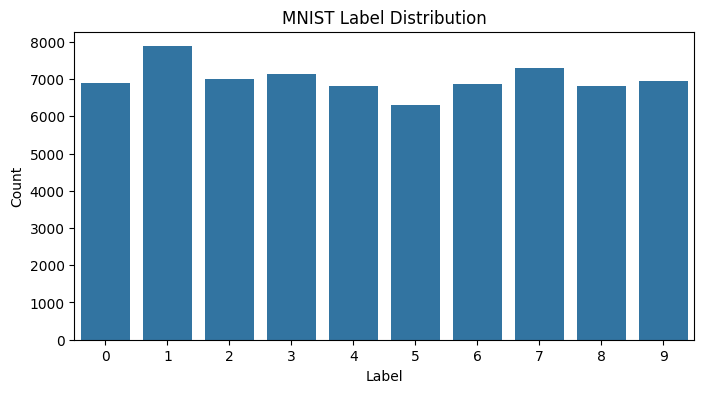

In [8]:
plt.figure(figsize=(8,4))
sns.countplot(x=y_all)
plt.title("MNIST Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### **3.3 Data Visualization**

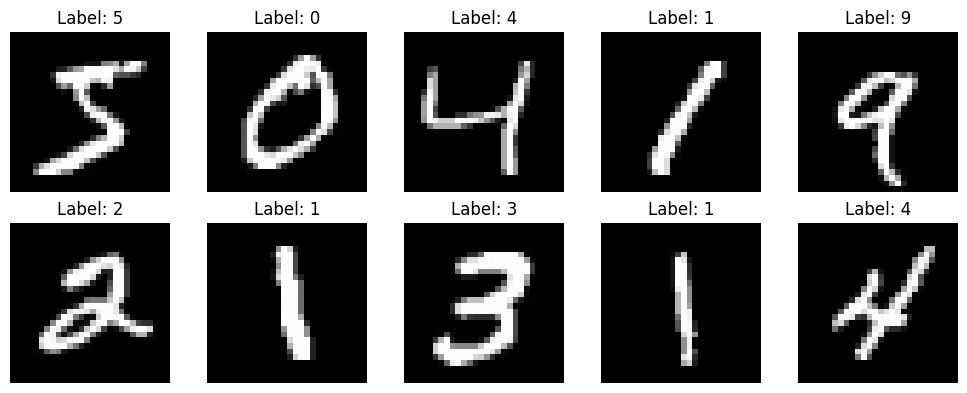

In [9]:
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_all[i], cmap='gray')
    plt.title(f"Label: {y_all[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### **3.4 Mean image per class**

Visualize the “average pattern” of each class

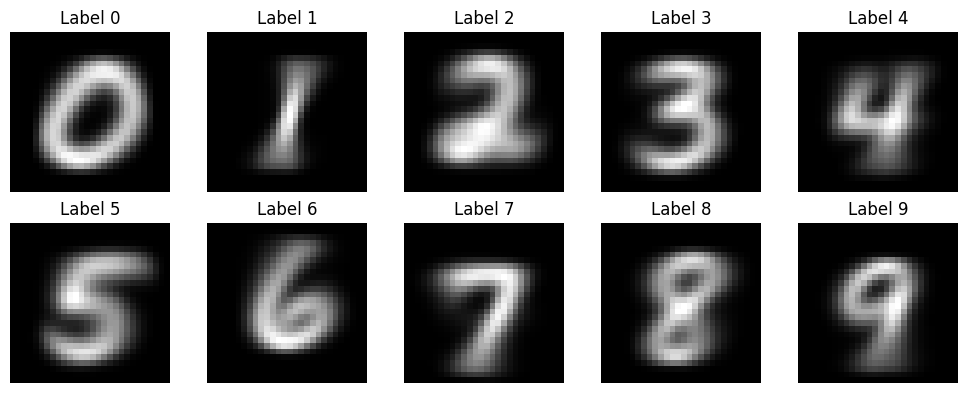

In [10]:
mean_images = []
for label in np.unique(y_all):
    mean_img = X_all[y_all == label].mean(axis=0)
    mean_images.append(mean_img)

plt.figure(figsize=(10,4))
for i, img in enumerate(mean_images):
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

==> The mean images show clear visual differences between classes, making the digits easy to distinguish by eye.

### **3.5 Pixel intensity distribution**

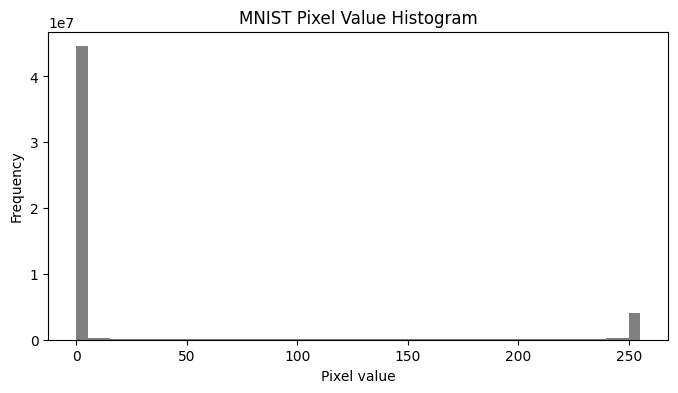

In [11]:
plt.figure(figsize=(8,4))
plt.hist(X_all.ravel(), bins=50, color='gray')
plt.title("MNIST Pixel Value Histogram")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

==> The histogram shows that most pixels are clustered near 0 and 255, with very few in between, indicating strongly black-and-white images with limited mid-tones.

### **Conclusion:**

The dataset is clean and does not require additional cleaning steps.

After analyzing the dataset from multiple perspectives, we can now proceed to Feature Engineering.

## **4. Image Feature Extraction**

During the model training process, three groups of image features were constructed:

**Normalization Features**
- Normalize pixel values to \([0, 1]\).
- Flatten the image into a feature vector.

**Edge Normalization Features**
- Evaluate two edge detection filters:
  - **Canny edge detector**
  - **Sobel operator** (used as the default)
- These features highlight contours and digit shapes.

**Block Averaging Features**
- Divide the image into small blocks.
- Compute the average value of each block to reduce dimensionality while preserving the overall structure of the image.


### **4.1 Normalization**

In [ ]:
def normalize_pixels(X):
    return X / 255.0 

### **4.2 Edge Normalization**
Using both Sobel and Canny

In [ ]:
def apply_sobel_edge(X):
    
    edges = np.array([
        np.sqrt(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)**2 + 
                cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)**2)
        for img in X
    ], dtype=np.float32)
    
    edges = np.array([e / (e.max() + 1e-8) for e in edges], dtype=np.float32)
    
    return edges

def apply_canny_edge(X):
    if X.dtype != np.uint8:
        X_uint8 = X.astype(np.uint8)
    else:
        X_uint8 = X
    
    edges = np.array([cv2.Canny(img, 100, 200) for img in X_uint8], dtype=np.float32)
    
    edges = np.array([e / 255.0 for e in edges], dtype=np.float32)

    return edges

### **4.3 Block Averaging**

In [ ]:
def apply_block_averaging(X, block_size=2):
    if isinstance(block_size, int):
        bh = bw = block_size
    else:
        bh, bw = block_size
        
    N, H, W = X.shape

    new_h = H // bh
    new_w = W // bw
    
    valid_h = new_h * bh
    valid_w = new_w * bw

    X_cropped = X[:, :valid_h, :valid_w]

    blocked = X_cropped.reshape(N, new_h, bh, new_w, bw)

    return blocked.mean(axis=(2, 4))

## **5. Feature Vector Designs**

### **5.1 Method 1: Normalization**

In [ ]:
def normalization_Function(x_train, y_train, x_test, y_test):

    x_train_nor = normalize_pixels(x_train)
    x_test_nor  = normalize_pixels(x_test)
    
    x_new_train = x_train_nor.reshape(len(x_train_nor), -1)  # (60000, 784)
    x_new_test  = x_test_nor.reshape(len(x_test_nor), -1)    # (10000, 784)
    
    return x_new_train, y_train, x_new_test, y_test

### **5.2 Method 2: Edge Normalization**


Function 2 combines normalized and edges. Output is a 1D array. All images are merged compared to the original image

In [ ]:
def edge_normalization_Function(x_train, y_train, x_test, y_test, method='sobel'):
    x_train_nor = normalize_pixels(x_train)
    x_test_nor  = normalize_pixels(x_test)

    x_train_edges = None
    x_test_edges  = None

    if method == 'sobel':
        x_train_edges = apply_sobel_edge(x_train_nor) 
        x_test_edges  = apply_sobel_edge(x_test_nor)

    elif method == 'canny':
        x_train_edges = apply_canny_edge((x_train_nor * 255).astype(np.uint8))
        x_test_edges  = apply_canny_edge((x_test_nor * 255).astype(np.uint8))

    if x_train_edges is not None:
        X_new_train = np.stack([x_train_nor, x_train_edges], axis=-1)
        X_new_test  = np.stack([x_test_nor, x_test_edges], axis=-1)
    else:
        X_new_train = x_train_nor[..., np.newaxis]
        X_new_test  = x_test_nor[..., np.newaxis]

    x_new_train = X_new_train.reshape(X_new_train.shape[0], -1)
    x_new_test  = X_new_test.reshape(X_new_test.shape[0], -1)
    
    return x_new_train, y_train, x_new_test, y_test

### **5.3 Method 3: Block Averaging**

*Feature engineering*

In [ ]:
def block_averaging_Function(x_train, y_train, x_test, y_test):
    
    x_train_nor = normalize_pixels(x_train)
    x_test_nor  = normalize_pixels(x_test)

    x_train_avg = apply_block_averaging(x_train_nor)
    x_test_avg = apply_block_averaging(x_test_nor)

    x_new_train = x_train_avg.reshape(len(x_train_avg), -1)
    x_new_test = x_test_avg.reshape(len(x_test_avg), -1)
    
    return x_new_train, y_train, x_new_test, y_test